**Skin Cancer Detection**

**1 Introduction**

Skin cancer effects many people around the world. Skin cancer is the most common malignancy in humans. Skin cancer is considered one of the deadliest dermatological diseases and is caused by unregulated cell growth on the skin surface, primarily on skin exposed to the sun, primarily the scalp, face, lips, ears, neck, chest, arms, and legs [1]. It is usually diagnosed visually, beginning with a clinical screening, followed by a dermoscopic examination, a biopsy, and a histopathological evaluation. So, identifying someone with or at a risk of skin cancer could help to take measures right away to lower their risk or destroy any cancer (if developed) at an early stage. Therefore, building an automatic system for the classification of skin lesions would help detect a malignancy.
In the project, we are using Convolutional Neural Networks (CNN) to accurately classify pigmented skin lesion in dermoscopic images to detect the malignant skin lesions as early as possible. CNNs are a class of deep neural network that use convolution instead of general matrix multiplication in at least one of their layers. They excel in analyzing visual imagery because they are fully-connected (FC) feed-forward networks that reduce the number of parameters very efficiently without losing out on the quality of models [2]. Two convolutional neural networks with varied architecture and/or depth, as well as data pre-processing methods, are examined in the project to see how they affect classification performance of skin lesions. The models used are CNN architecture VGG16Net and InceptionNet-V3.

VGG16Net: VGG16Net [3] is a 16-layer CNN model with very small convolution filters and an architecture of increasing depths. In 2014, the model won first place in the ImageNet recognition competition, with a top-5 test accuracy of 92.7 %.

InceptionNet-V3: InceptionV3 [4] is the third version of Google's Inception CNN, which is frequently utilized. It's a 48-layer model that first appeared in the ImageNet identification challenge in 2015, where it came in second place. In the challenge, it achieved an accuracy of 78.1 percent.


**2 Dataset**

In this project, we aim to classify skin lesion categories in images by building the most accurate machine learning model for the HAM10000 dataset ("Human Against Machine with 10000 training images"). This will help doctors to quickly identify high priority patients and speed up their work-process. The dataset consists of 10015 dermatoscopic images, which were released as a training set for academic ML purposes and are publicly available through the ISIC archive. (https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000).

The dataset includes 7 attributes associated with each image and patient:

*   a lesion_id [lesion_id]
*   a unique image_id [image_id]
*   a diagnostic skin lesion category [dx] [To be predicted in our tests]
*   a technical validation field type, which indicates how the skin lesion diagnosis was made [dx_type]
*   the patient’s age [age]
*   the patient’s sex [sex]
*   the localization of the skin lesion [localization]

The 7 different diagnostic skin lesion categories to be predicted are:

* Melanocytic Nevi [nv] are benign melanocyte neoplasms that come in a variety of forms. From a dermatoscopic perspective, the variants may differ dramatically. [6705 photos]
* Melanoma [mel] is a malignant tumour that arises from melanocytes and comes in a variety of forms. It can be treated by simple surgical excision if caught early enough. [1113 photos]
* Benign Keratosis-like Lesions [bkl]: A flat variety of seborrheic keratosis and lichen-planus-like keratoses (LPLK), which is a seborrheic keratosis or solar lentigo with inflammation and regression. [1099 photos]
* Basal Cell Carcinoma [bcc]:  is a type of epithelial skin cancer that seldom metastasizes but can be deadly if left untreated. [514 photos]
* 	Vascular Lesions [vasc]: These can be benign or malignant and vary from cherry angiomas to angiokeratomas and pyogenic granulomas. [142 photos]
*	Actinic Keratoses [akiec]: A type of squamous cell carcinoma that is non-invasive and can be treated locally without surgery. [327 photos]
* 	Vascular Lesions [vasc]: These can be benign or malignant and vary from cherry angiomas to angiokeratomas and pyogenic granulomas. [142 photos]



In [ ]:
! jupyter nbconvert --no-input --to html /content/SkinCancerDetection_A.ipynb

[NbConvertApp] Converting notebook /content/SkinCancerDetection_A.ipynb to html
[NbConvertApp] Writing 2369496 bytes to /content/SkinCancerDetection_A.html


**1. Importing Essential Libraries**

In [1]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [88]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import misc
from google.colab import files
import os
import zipfile

from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import keras
from keras import backend
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, VGG16, Xception
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Use this to supress warnings from scipy in the meantime
import warnings
warnings.filterwarnings("ignore")


**Loading the Kaggle API since we are downloading dataset from kaggle**

In [3]:
files.upload()
!mkdir ~/.kaggle    #create a kaggle folder
!cp kaggle.json ~/.kaggle  #copying the kaggle.json file to folder
!chmod 600 /root/.kaggle/kaggle.json #permission for the json to act
import kaggle
print("Imported kaggle API successfully !")

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pillasatish","key":"64f953b34405ac05a08125b0c24aa033"}'}

Imported kaggle API successfully !


**Downlaoding the dataset**

In [4]:
%%capture
print("Downloading dataset : ")
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
print("Downloaded Successfully!")

**Unzipping the HAM10000 datafile**

In [5]:
%%capture
!unzip skin-cancer-mnist-ham10000.zip 

**Extracting Images into single directory**

In [6]:
%%capture
print('Extracting Images into single directory')
os.mkdir('images')
!cp -av 'HAM10000_images_part_1' 'images'
!cp -av 'HAM10000_images_part_2' 'images'
print('Succesfully extracted Images into single directory')

**Exploratory data analysis**

**Preprocessing the HAM10000_metadata.csv**

In [7]:
df=pd.read_csv('HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Creating a dictionary to feed in label values in our dataframe.

In [8]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

Adding new columns to the imported dataset for better readability & analysis

In [9]:
df['celltype']=df['dx'].map(lesion_type_dict.get)
df['cell_type_idx']=pd.Categorical(df['celltype']).codes #Converting each lesion to a numerical code.

In [10]:
from glob import glob
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}

In [11]:
df['path'] = df['image_id'].map(image_path.get)
df.head()

lesion_id  ...                                     path
0  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0027419.jpg
1  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0025030.jpg
2  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0026769.jpg
3  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0025661.jpg
4  HAM_0001466  ...  ham10000_images_part_2/ISIC_0031633.jpg

[5 rows x 10 columns]

**Numerical Analysis**

Checking the dimension and attributes of each type.

In [12]:
print(df.shape)
print(df.info())


(10015, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   celltype       10015 non-null  object 
 8   cell_type_idx  10015 non-null  int8   
 9   path           10015 non-null  object 
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB
None


Descriptive statistics about the dataset( (excluding numeric types: age and cell_type_idx)

In [13]:
df.describe(exclude=[np.number])

lesion_id  ...                                     path
count         10015  ...                                    10015
unique         7470  ...                                    10015
top     HAM_0005263  ...  HAM10000_images_part_1/ISIC_0028296.jpg
freq              6  ...                                        1

[4 rows x 8 columns]

Descriptive statistics about the dataset's numeric types: age and cell_type_idx

In [14]:
df.describe()

age  cell_type_idx
count  9958.000000   10015.000000
mean     51.863828       3.623964
std      16.968614       1.208859
min       0.000000       0.000000
25%      40.000000       4.000000
50%      50.000000       4.000000
75%      65.000000       4.000000
max      85.000000       6.000000

**Cleaning the dataset**

From the above stat we can clearly see that there are only 7470 unique lesion_id's, so let's filter them out.

In [15]:
df = df.drop_duplicates(subset='lesion_id')
df.head(5)

lesion_id  ...                                     path
0  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0027419.jpg
2  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0026769.jpg
4  HAM_0001466  ...  ham10000_images_part_2/ISIC_0031633.jpg
6  HAM_0002761  ...  HAM10000_images_part_1/ISIC_0029176.jpg
8  HAM_0005132  ...  HAM10000_images_part_1/ISIC_0025837.jpg

[5 rows x 10 columns]

Check if there are any missing values are present in the dataset.

In [16]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
celltype          0
cell_type_idx     0
path              0
dtype: int64

From above we can see that age column has 52 null values, so we will fill the null values with the mean of the age column.
Replacing NA values in age with the age mean in the dataset.

In [17]:
print(df['age'].mean())
df['age'].fillna(df['age'].mean(),inplace=True) #filling the null values with the mean of age
print(df.isnull().sum()) #reverfying if there are any values present or not

51.65880291183608
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
celltype         0
cell_type_idx    0
path             0
dtype: int64


**Graphical summary**

**Skin Cancer by Class**

For the project we are predicting the cancer type, so let's check the distribution of the values.

<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Skin Cancer by Class')

Text(0.5, 0, 'Skin Cancer Class')

Text(0, 0.5, 'Number of Data Points')

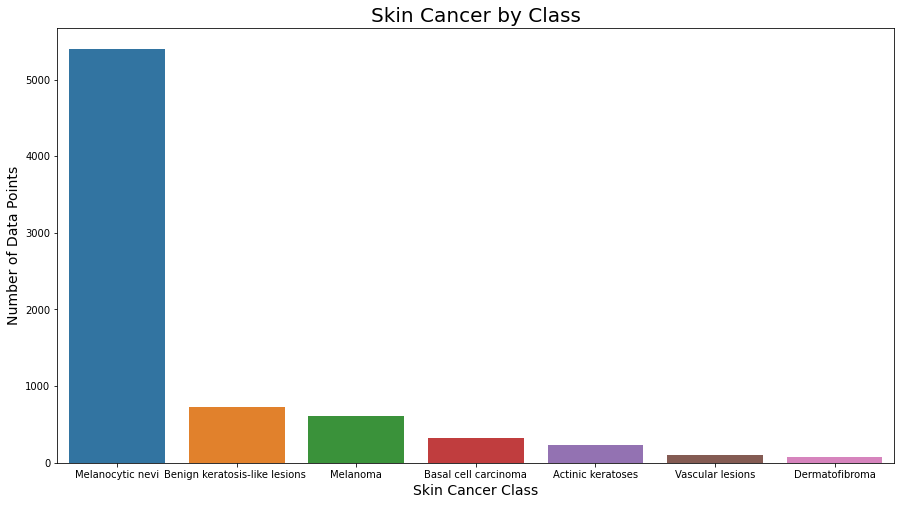

In [18]:
plt.figure(figsize=(15,8))
cancer_typ=sns.countplot(df['celltype'],order=df['celltype'].value_counts().index)
cancer_typ.set_title('Skin Cancer by Class', fontsize=20)
cancer_typ.set_xlabel('Skin Cancer Class', fontsize=14)
cancer_typ.set_ylabel('Number of Data Points', fontsize=14)


In [19]:
df['celltype'].value_counts()

Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: celltype, dtype: int64


From above we can clearly see that we have 7 different cancer types and most people are suffering from Melanocytic nevi [nv] cancer. Out of 10000 people 5403 people are suffering from Melanocytic nevi [nv] cancer. 614 people are suffering form Melanoma [mel], 727 are sufferning from Benign keratosis-like lesions [bkl], 327 are suffering from Basal cell carcinoma [bcc], 228 are suffering from Actinic keratoses [akiec], 98 are suffering form Vascular lesions [vasc], the least cancer type class is Dermatofibroma [df], only 73 people are suffering.

There is a class imbalance with Melanocytic nevi[nv], comprising more than 65% of overall data.


**Skin Caner by Hispathology**

Text(0.5, 1.0, 'Skin Cancer by Histopathology')

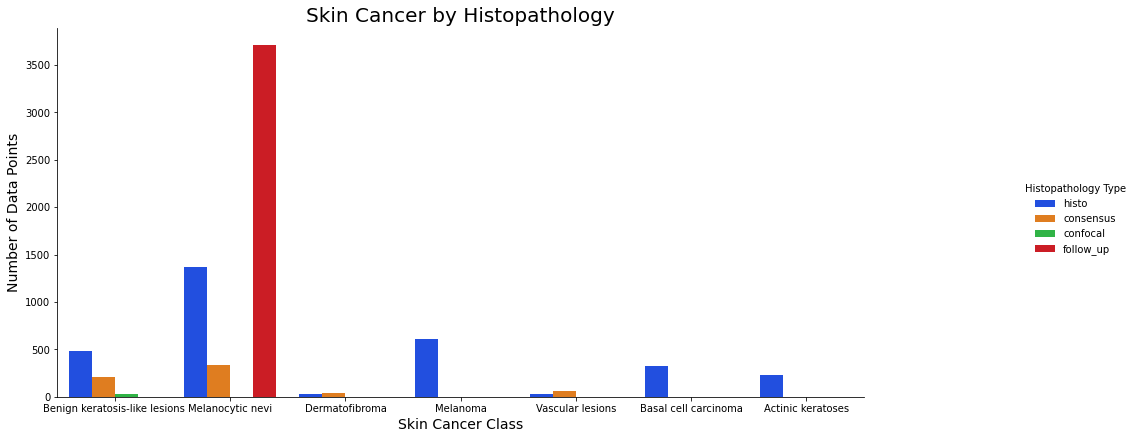

In [20]:
# Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="celltype", kind="count", hue="dx_type", palette='bright', data=df)
g.fig.set_size_inches(18, 6)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Histopathology Type')

From above we can clearly see that the majority of the technical validation were either by histograms or follows-up. For the Melanocytic nevi [nv] the confirmation is done majority through follow-ups.

**Skin Cancer by Body Localization**

Text(0.5, 1.0, 'Skin Cancer by Localization')

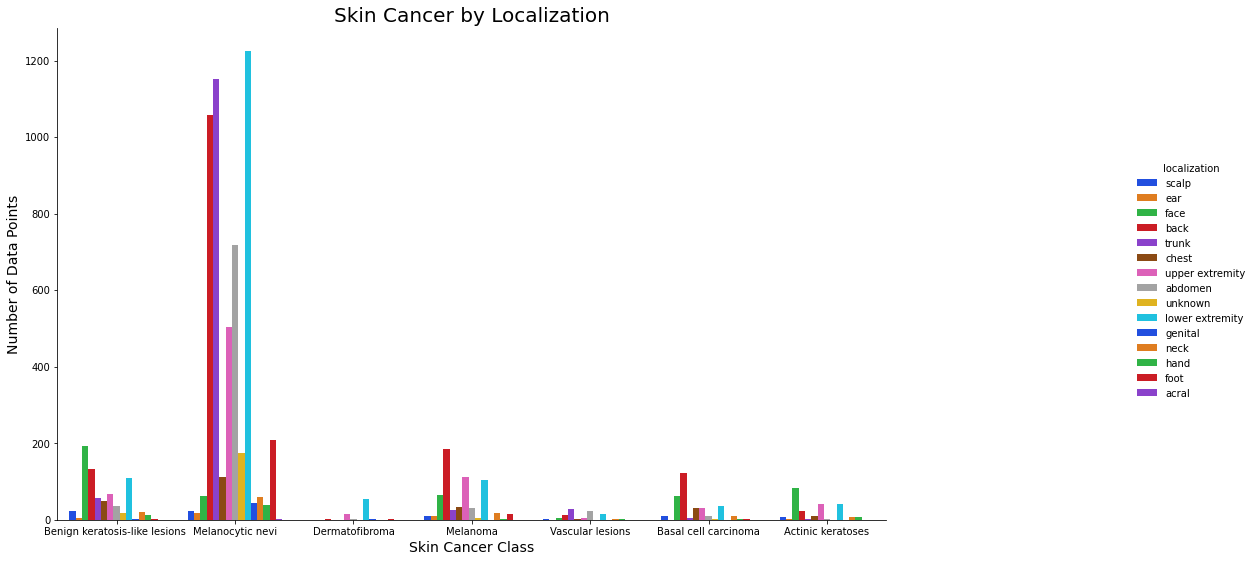

In [21]:
# Skin Cancer occurence body localization
body_loc = sns.catplot(x="celltype", kind="count", hue="localization", palette='bright', data=df)
body_loc.fig.set_size_inches(20, 8)

body_loc.ax.set_title('Skin Cancer by Localization', fontsize=20)
body_loc.set_xlabels('Skin Cancer Class', fontsize=14)
body_loc.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Localization')

We can see that skin cancer as more occurrence in the back, lower extremity and trunk of the people. 

**skin Cancer by Gender**

Text(0.5, 1.0, 'Skin Cancer by Sex')

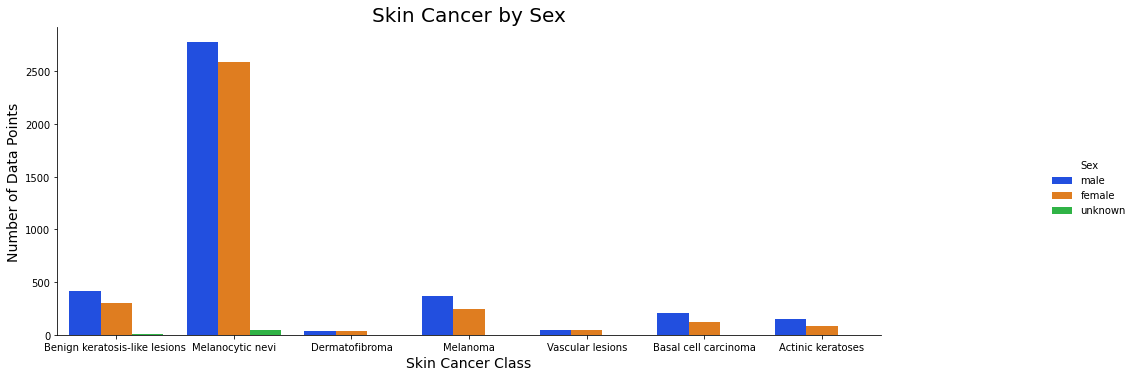

In [22]:
# Skin Cancer occurence by Gender
gender= sns.catplot(x="celltype", kind="count", hue="sex", palette='bright', data=df)
gender.fig.set_size_inches(18, 5)

gender.ax.set_title('Skin Cancer by Sex', fontsize=20)
gender.set_xlabels('Skin Cancer Class', fontsize=14)
gender.set_ylabels('Number of Data Points', fontsize=14)
gender._legend.set_title('Sex')

We can see that there is equal distribution of cancer types among male and female, Melanocytic nevi [nv] is the most common cancer among both male and female.

**Skin Cancer by Age**

Text(0.5, 1.0, 'Skin Cancer by Age')

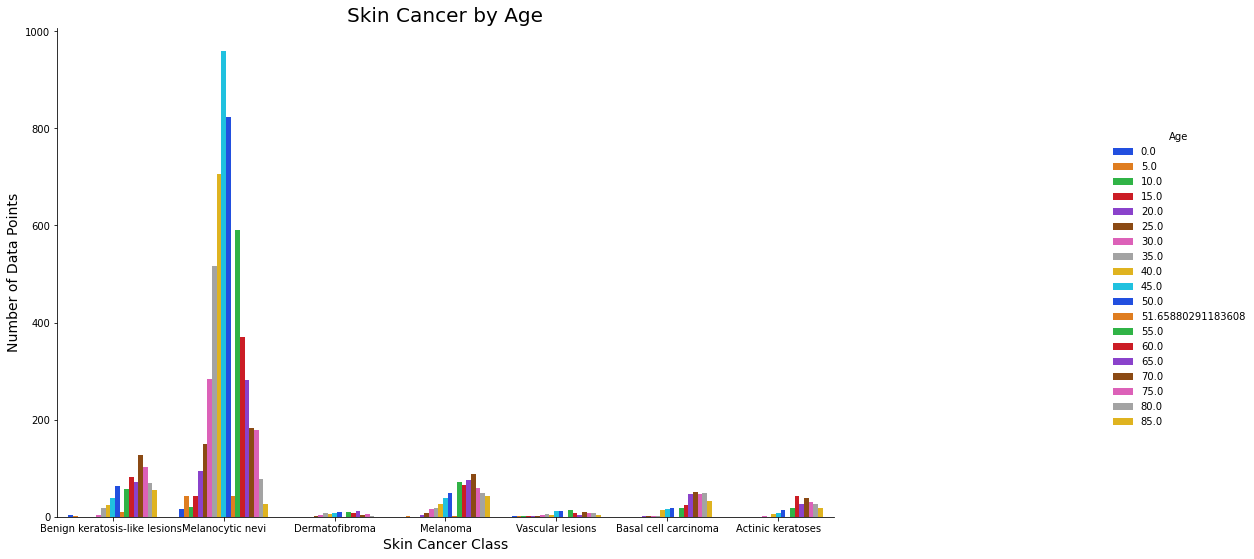

In [23]:
# Skin Cancer by Age
age= sns.catplot(x="celltype", kind="count", hue="age", palette='bright', data=df)
age.fig.set_size_inches(20, 8)

age.ax.set_title('Skin Cancer by Age', fontsize=20)
age.set_xlabels('Skin Cancer Class', fontsize=14)
age.set_ylabels('Number of Data Points', fontsize=14)
age._legend.set_title('Age')

Again, from above we can clearly see that most common cancer is Melanocytic nevi [nv] in the dataset, it seems to occur at middle age for other cancer class, it seems to occur more at a later 
age.


**Processing and resizing the Images to build the model**

Let's find the width and height of the images

In [24]:
im=pil_image.open(df['path'][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


The width and height sizes may cause an issue while training the ML model,due to the huge amount of images present in the dataset. The ML model will take lot time to process the image, to speed the process we will reduce the image size it to 1:4 ratio.

Resize the images and add the image pixels values as a new column too the df dataframe.

In [25]:
df['image']=df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))

Check 5 entries of df dataframe

In [26]:
df.head(5)

lesion_id  ...                                              image
0  HAM_0000118  ...  [[[188, 151, 193], [193, 156, 198], [192, 155,...
2  HAM_0002730  ...  [[[186, 126, 135], [189, 131, 142], [192, 136,...
4  HAM_0001466  ...  [[[129, 87, 109], [139, 94, 117], [148, 102, 1...
6  HAM_0002761  ...  [[[190, 144, 125], [191, 145, 129], [193, 146,...
8  HAM_0005132  ...  [[[95, 61, 61], [105, 71, 71], [114, 77, 77], ...

[5 rows x 11 columns]

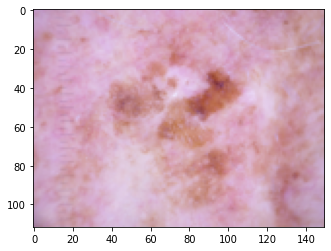

In [27]:
plt.imshow(df['image'][0])

In [28]:
df['celltype'][0]

'Benign keratosis-like lesions '

In [29]:
df['image'][0].shape

(112, 150, 3)

Plotting 5 images of each class

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

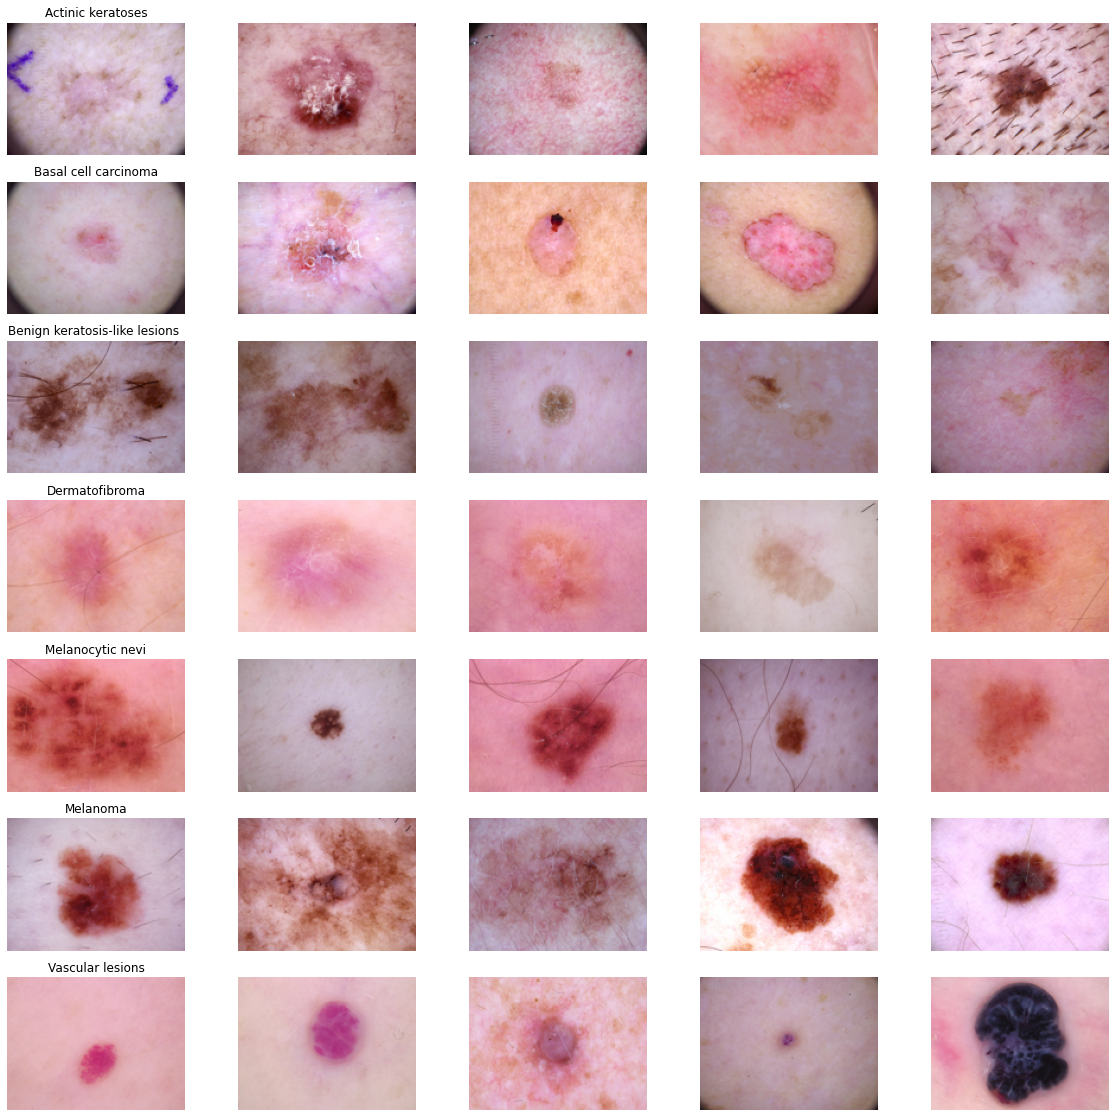

In [30]:
fig,axes=plt.subplots(7,5,figsize=(20,20))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,df.sort_values(['celltype']).groupby('celltype')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

**Feature and Target Split**

In [31]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']


**Training, Validation and Test Split**

We first split the dataset to 80% training data and 20% testing data. We then take the 80% training data and split it into 87.5% training data and 12.5% validation data, to form our 70% Training - 10% Validation - 20% Testing. Note that the split will be applied across each class individually to ensure there is enough samples from each class in each split for accurate modeling, meaning each class will be split 70:10:20 as well. This is done by setting 'stratify' in train_test_split function to our target.

Training: 80% 87.5% = 70%
Validation: 80% 12.5% = 10%
Testing: 20%

In [32]:
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,stratify=target)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

**Feature Normalization**

In [34]:
X_train_normal = np.asarray(X_train['image'].tolist())
X_test_normal = np.asarray(X_test['image'].tolist())
X_val_normal=np.asarray(X_val['image'].tolist())

In [35]:
#calculating the train mean and standard deviation
X_train_mean=np.mean(X_train_normal)
X_train_sd=np.std(X_train_normal)
#Normalizing the each image by substracting it's value with training mean value and then dividing by the training standard deviation
X_train_normal=(X_train_normal-X_train_mean)/X_train_sd
X_test_normal=(X_test_normal-X_train_mean)/X_train_sd
X_val_normal=(X_val_normal-X_train_mean)/X_train_sd

**Target One-Hot Encoding**

Creating one-hot vectors of size (1,7) for each label

This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value, producing the (1,7) row vector in our case as we have 7 unique label integer values. This is needed as there is no ordinal relationship between the label's integer values. It eliminates any natural integer ordering assumption the ML algorithm may conclude.

In [36]:
num_classes = 7
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

**Reshaping Images**

In [37]:
input_shape=(150,112,3)
X_train_normal=X_train_normal.reshape(X_train_normal.shape[0],*(input_shape))
X_test_normal=X_test_normal.reshape(X_test_normal.shape[0],*(input_shape))
X_val_normal=X_val_normal.reshape(X_val_normal.shape[0],*(input_shape))

In [38]:
X_train_normal.shape

(4780, 150, 112, 3)

**Data Augmentation**
The images will be:
* Randomly rotated by 20%
* Randomly shifted horizontally by 20%
* Randomly shifted vertically by 20%
* Randomly sheared by 10%
* Randomly zoomed by 10%
* Randomly channel shifted by 10%

In [39]:
augmented_data = ImageDataGenerator(zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1)

In [40]:
augmented_data.fit(X_train_normal)

**Building a Model: Using Transfer Learning - VGG16 model**

VGG16 model:VGG16 is a 16-layered convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition” (https://arxiv.org/abs/1409.1556). The model achieved 92.7% top-5 test accuracy in ImageNet.

**Deafult VGG16 model**

In [41]:
VGG16_model=VGG16(weights='imagenet')
VGG16_model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Default VGG16 model except image size to be (224,244,3), but our image sizes are different, so we need to change the parameter image size in the first layer. Our size will be (150,112,3). Our problem consists of 7 classifications, so we are excluding the top layer and customizing it.

**Custom_VGG16 model**

In [42]:
input_layer=layers.Input(shape=(150,112,3))
base_vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer, pooling=None, classes=7)
base_vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 56, 128)       147584    
                                                              

From above custom VGG16 model we can clearly see that the first layer is having image size = (150,112,3) and we can also see that 2 top(last layers) which were orginally present in the VGG16 model are now not the part of our customized layer because we have set include_top= False.

**Customizing the last(top layer)**



In [43]:
# access the current last layer of the model and add flatten and dense after it

print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=base_vgg_model.output # we are taking last layer of the model
# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 
# Add dense layer to the final output layer
output_layer=layers.Dense(7,activation='softmax')(flatten)

# Creating model with input and output layer
VGG16_custom_model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
VGG16_custom_model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 112, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 112, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 56, 128)       147584    
                     

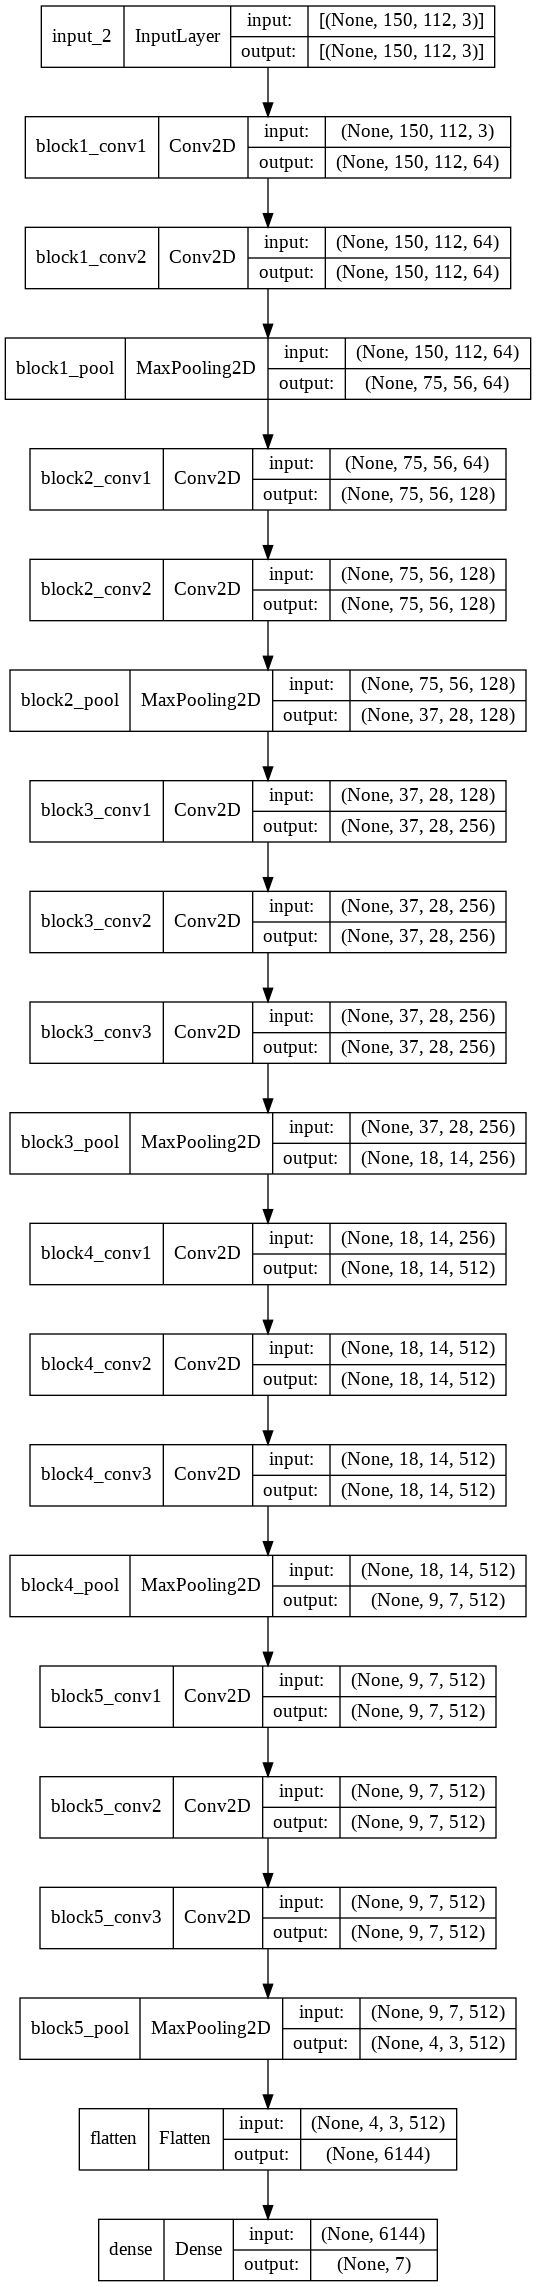

In [44]:
plot_model(VGG16_custom_model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
#Image(retina=True, filename='simple_model_plot.png')

**Compiling the model**

In [45]:
VGG16_custom_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
print("Model compilation completed.")

Model compilation completed.


**Setting a learning rate reduction callback (used across both the models)**

In [46]:
callbacks = [EarlyStopping(monitor='accuracy',patience=4)]

**Hyperparameter values (used across two models)**

In [48]:
epochs = 25
batch_size = 10
steps_per_epoch = len(X_train_normal) / 10

**Fitting the model**

In [49]:
VGG16_results = VGG16_custom_model.fit(augmented_data.flow(X_train_normal,y_train,batch_size=batch_size),
                                       epochs=epochs,verbose=1,
                                       validation_data=(X_val_normal,y_val),steps_per_epoch = steps_per_epoch,callbacks=callbacks)

Epoch 1/25
478/478 [==============================] - 52s 81ms/step - loss: 1.1094 - accuracy: 0.7199 - val_loss: 1.0386 - val_accuracy: 0.7232
Epoch 2/25
478/478 [==============================] - 35s 73ms/step - loss: 1.0304 - accuracy: 0.7220 - val_loss: 1.0419 - val_accuracy: 0.7232
Epoch 3/25
478/478 [==============================] - 34s 72ms/step - loss: 1.0358 - accuracy: 0.7234 - val_loss: 1.0211 - val_accuracy: 0.7232
Epoch 4/25
478/478 [==============================] - 34s 72ms/step - loss: 1.0308 - accuracy: 0.7234 - val_loss: 1.0168 - val_accuracy: 0.7232
Epoch 5/25
478/478 [==============================] - 34s 72ms/step - loss: 1.0539 - accuracy: 0.7222 - val_loss: 1.0325 - val_accuracy: 0.7232
Epoch 6/25
478/478 [==============================] - 34s 72ms/step - loss: 1.1101 - accuracy: 0.7186 - val_loss: 1.0167 - val_accuracy: 0.7232
Epoch 7/25
478/478 [==============================] - 34s 71ms/step - loss: 1.0191 - accuracy: 0.7234 - val_loss: 1.0178 - val_accuracy:

**Plotting the training, validation accuracy values and training,validation loss values**

Text(0.5, 1.0, 'VGG16Net_model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

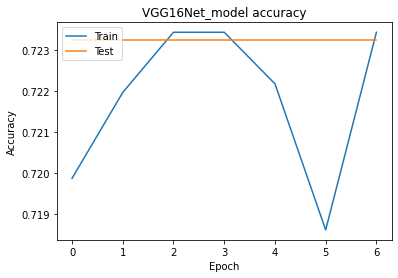

Text(0.5, 1.0, 'VGG16Net_model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

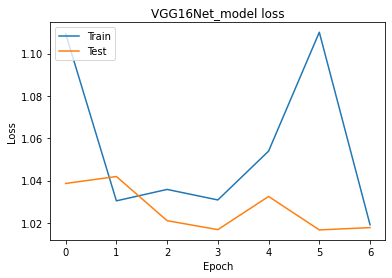

In [50]:
# Plot training & validation accuracy values
plt.plot(VGG16_results.history['accuracy'])
plt.plot(VGG16_results.history['val_accuracy'])
plt.title('VGG16Net_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(VGG16_results.history['loss'])
plt.plot(VGG16_results.history['val_loss'])
plt.title('VGG16Net_model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Predict probabilities and classes for test set**

In [70]:
yhat_prob=VGG16_custom_model.predict(X_test_normal)
yhat_classes=np.argmax(yhat_prob,axis=1)
print(yhat_classes)
y_true_classes = np.argmax(y_test, axis = 1)
print(y_true_classes)

[4 4 4 ... 4 4 4]
[4 4 4 ... 4 4 5]


**Accuracy,precision and recall values**

In [90]:
accuracy_VGG16=accuracy_score(y_true_classes,yhat_classes)
print("Accuracy: %f" % accuracy_VGG16)
precision_VGG16=precision_score(y_true_classes,yhat_classes,average='weighted')
print("Precision: %f" % precision_VGG16)
recall_VGG16=recall_score(y_true_classes,yhat_classes,average='weighted')
print("Recall: %f" % recall_VGG16)

Accuracy: 0.722892
Precision: 0.522572
Recall: 0.722892


Original Shape of image is :  (112, 150, 3)


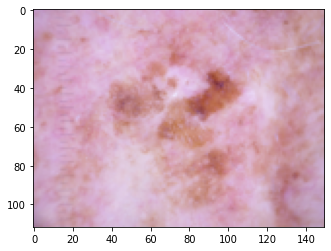

In [91]:
test_image = df['image'][0]
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [92]:
test_image=np.asarray(test_image.tolist())
test_image = test_image.reshape(1,150,112,3)

In [93]:

prediction_class = VGG16_custom_model.predict(test_image)
np.argmax(prediction_class,axis=1)
print(prediction_class)


array([4])

[[0.0253934  0.03245969 0.12474733 0.01098356 0.7111772  0.081818
  0.0134208 ]]


**Building a Model: Using Transfer Learning -InceptionV3:**

InceptionV3 is the third version of Google's Inception CNN, which is frequently utilised. It's a 48-layer model that first appeared in the ImageNet identification challenge in 2015, where it came in second place. In the challenge, it achieved an accuracy of 78.1 percent or higher.

**Default InceptionV3**

In [47]:
Inception_model=InceptionV3(weights="imagenet")
Inception_model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

Default InceptionV3 model except image size to be(229,229,3), but our image size's are different, so we need to change the parameter image size in the first layer. Our size will be (150,112,3). Our problem consist of 7 classifiction, so we are exculding the top layer.

In [59]:
base_inception_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=input_layer)
base_inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 55, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 55, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

From above custom inceptionV3 model we can clearly see that the first layer is having image size = (150,112,3) and we can also see that 2 top(last layers) which were orginally present in the inceptionV3 model are now not the part of our customized layer because we have set include_top= False.

**Customizing the last(top layer)**

In [60]:
# access the current last layer of the model and add flatten and dense after it

print("Summary of Custom inception model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=base_inception_model.output # we are taking last layer of the model
# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 
# Add dense layer to the final output layer
output_layer=layers.Dense(7,activation='softmax')(flatten)

# Creating model with input and output layer
inception_custom_model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
inception_custom_model.summary()

Summary of Custom inception model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 55, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 55, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                  

In [62]:
plot_model(inception_custom_model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
#Image(retina=True, filename='simple_model_plot.png')

**compling the model**

In [61]:
inception_custom_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
print("Model compilation completed.")

Model compilation completed.


**Fitting model**

In [63]:
inception_result=inception_custom_model.fit(augmented_data.flow(X_train_normal,y_train,batch_size=batch_size),epochs=epochs,verbose=1,validation_data=(X_val_normal,y_val),steps_per_epoch = steps_per_epoch,callbacks=callbacks)

Epoch 1/25
478/478 [==============================] - 60s 90ms/step - loss: 1.5897 - accuracy: 0.7033 - val_loss: 1784.1204 - val_accuracy: 0.7166
Epoch 2/25
478/478 [==============================] - 37s 78ms/step - loss: 1.1834 - accuracy: 0.7096 - val_loss: 142.0523 - val_accuracy: 0.7232
Epoch 3/25
478/478 [==============================] - 38s 79ms/step - loss: 1.1573 - accuracy: 0.7121 - val_loss: 0.9569 - val_accuracy: 0.7232
Epoch 4/25
478/478 [==============================] - 38s 79ms/step - loss: 1.1130 - accuracy: 0.7113 - val_loss: 2.0112 - val_accuracy: 0.6982
Epoch 5/25
478/478 [==============================] - 38s 79ms/step - loss: 1.0687 - accuracy: 0.7121 - val_loss: 5.2878 - val_accuracy: 0.7232
Epoch 6/25
478/478 [==============================] - 37s 78ms/step - loss: 1.0128 - accuracy: 0.7136 - val_loss: 0.8599 - val_accuracy: 0.7232
Epoch 7/25
478/478 [==============================] - 37s 77ms/step - loss: 0.9735 - accuracy: 0.7172 - val_loss: 0.9259 - val_accu

**Plot training,validation accuracy values and training,validation loss values**

Text(0.5, 1.0, 'Inception_model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

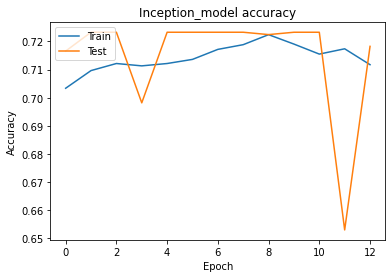

Text(0.5, 1.0, 'Inception_model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

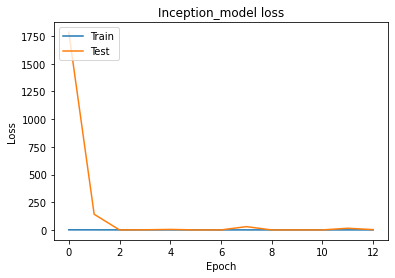

In [65]:
# Plot training & validation accuracy values
plt.plot(inception_result.history['accuracy'])
plt.plot(inception_result.history['val_accuracy'])
plt.title('Inception_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(inception_result.history['loss'])
plt.plot(inception_result.history['val_loss'])
plt.title('Inception_model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Predict probabilities and classes for test set**

In [ ]:
yhat_prob=inception_custom_model.predict(X_test_normal)
yhat_classes=np.argmax(yhat_prob,axis=1)
print(yhat_classes)
y_true_classes = np.argmax(y_test, axis = 1)
print(y_true_classes)


**Accuracy,precision and recall values**

In [ ]:
accuracy_VGG16=accuracy_score(y_true_classes,yhat_classes)
print("Accuracy: %f" % accuracy_VGG16)
precision_VGG16=precision_score(y_true_classes,yhat_classes,average='weighted')
print("Precision: %f" % precision_VGG16)
recall_VGG16=recall_score(y_true_classes,yhat_classes,average='weighted')
print("Recall: %f" % recall_VGG16)